## Data Handler

In [12]:
import pandas as pd


class DataHandler:
    """
        chargement du dataset dans une classe
    """
    def __inti__(self):
        self.df_vgsales

    def get_data(self):
        """
            charge les datasets des csv
        """
        self.df_vgsales = pd.read_csv('vgsales.csv', delimiter=",", index_col=0)
        print("Dataset chargés ")



## Feature Recipe 

In [23]:
import pandas as pd


class FeatureRecipe:

    def __init__(self, data):
        self.df = data
        self.categories = []
        self.floats = []
        self.int = []
        self.drop = []

    def dropNaNPourcentage(self, seuil):
        """
            drop la colonne suivant un seuil %( param)
        """
        for colonne in self.df:
            nbNaN = self.df[colonne].isna().sum()
            if (nbNaN / self.df.shape[0]) * 100 > seuil:
                del self.df[colonne]
                print('{} supprimée'.format(colonne))

    def dropUselessFeature(self):
        to_drop = [] # a remplir suivant les colonnes qui sont inutiles
        self.df.drop(columns=to_drop, inplace=True)
        for colonne in self.df:
            if self.df[colonne].nunique() <= 1:
                print('{} supprimée'.format(colonne))
                del self.df[colonne]

    def dropDuplicates(self):
        """
            drop des duplica de colonnes
        """
        i = 0
        for colonnes in self.df:
            i += 1
            y = 0
            for colonnesDuplicate in self.df:
                y += 1
                if i != y and (self.df[colonnes].equals(self.df[colonnesDuplicate])) == True:
                    del self.df[colonnesDuplicate]
                    print('colonne {} supprimée'.format(colonnesDuplicate))

    def separeteVariableTypes(self):
        print("separating columns")
        for colonne in self.df.columns:
            if self.df[colonne].dtypes == int:
                self.int.append(self.df[colonne])
            elif self.df[colonne].dtypes == float:
                self.floats.append(self.df[colonne])
            else:
                self.categories.append(self.df[colonne])
        print("nombre de colonnes : {} \n \
            number of discreet values : {} \n \
            number of continuous values : {} \n \
            number of others : {} \n \
            taille total : {}".format(len(self.df.columns), len(self.int), \
                                      len(self.floats), len(self.categories),
                                      len(self.int) + len(self.floats) + len(self.categories)))
    
    def fillNaNDate(self):
        self.df.Year = self.df.Year.fillna(self.df.Year.mean())
        self.df.Year = self.df.Year.astype('float32')    
        
    def prepareData(self, seuil):
        self.fillNaNDate()
        self.dropUselessFeature()
        self.dropDuplicates()
        self.dropNaNPourcentage(seuil)
        self.separeteVariableTypes()

## FeatureExtractor

In [29]:
import pandas as pd

class FeatureExtractor:
    """
    Feature Extractor class
    """
    def __init__(self, data: pd.DataFrame, flist: list = None):
        """
            Input : pandas.DataFrame, feature list to drop
            Output : X_train, X_test, y_train, y_test according to sklearn.model_selection.train_test_split

        """
        self.df = data
        self.toDropList = flist
        self.X = self.df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].values
        self.y = self.df['Global_Sales'].values
        self.X_train, self.X_test, self.y_train, self.y_test = (),(),(),()
        
    def train(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=.2, random_state=30)

## ModelBuilder

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from datetime import date
import joblib
import sys

class ModelBuilder:
    """
        Class for train and print results of ml model
    """

    def __init__(self, model_path: str = None, save: bool = None):
        """
        constructeur 
        """
        self.model_filename = model_path
        self.saveModel = save
        self.date = date.today().isoformat()
        self.X_train, self.X_test, self.y_train, self.y_test = (), (), (), ()
        self.clf = ()

    def load_model(self):
        try:
            self.model_filename = "model_{}.joblib.z".format(self.date)
            clf = joblib.load(self.model_filename)
        except:
            print("Erreur a l'ouverturedu fichier : {}".format(sys.exc_info()[0]))

    def train(self, X, Y):
        """

        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, Y, test_size=.2, random_state=30)
        self.clf = LinearRegression()
        self.clf.fit(self.X_train, self.y_train)

    def predict_test(self, X):
        """
            calcul des predictions 
        """
        print('Debut predict_test ')
        predict = self.clf.predict(self.X_test)
        print('Fin predict_test')
        return predict

    def save_model(self, path: str):
        """
            Enregistrement du model 
        """
        if self.saveModel == True:
            print("enregistrement du model")
            model_filename = "model_{}.joblib.z".format(self.date)
            joblib.dump((self.clf), model_filename)
            print("enregistrement du model terminé")

    def print_accuracy(self):
        """
            affichage de la precision des predictions
        """
        accuracy = self.clf.score(self.X_test, self.y_test)
        print('precision : {}'.format(accuracy))

    def FeatureImportance(self):
        """
            attribut un score aux valeurs utilisé pour la prediction basé 
            sur leurs utilité
        """
        self.clf.fit(self.X_train, self.y_train)
        importance =  self.clf.coef_
        print('Feature importance :')
        for i,v in enumerate(importance):
            print('Feature: %0d, Score: %.5f' % (i,v))
        pyplot.bar([x for x in range(len(importance))], importance)
        pyplot.show()

    def crossValidation(self,X, Y):
        print("CrossValidation :")
        scores = cross_val_score(self.clf, X, Y, cv=5)
        print("%0.2f precision avec une deviation de %0.2f" % (scores.mean(), scores.std()))
    
    def calculData(self, X, Y):
        self.train(X, Y)
        self.predict_test(X)
        self.print_accuracy()
        self.save_model("")
        self.crossValidation(X, Y)
        self.FeatureImportance()

In [56]:
data = DataHandler()
data.get_data()

Dataset chargés 


In [57]:
featuresRecipe = FeatureRecipe(data.df_vgsales)
featuresRecipe.prepareData(3)

separating columns
nombre de colonnes : 10 
             number of discreet values : 0 
             number of continuous values : 5 
             number of others : 5 
             taille total : 10


In [58]:
extractor = FeatureExtractor(featuresRecipe.df)
extractor.train()

Debut predict_test 
Fin predict_test
precision : 0.999989546076212
CrossValidation :
0.96 precision avec une deviation de 0.05
Feature importance :
Feature: 0, Score: 0.99985
Feature: 1, Score: 1.00004
Feature: 2, Score: 0.99986
Feature: 3, Score: 0.99981


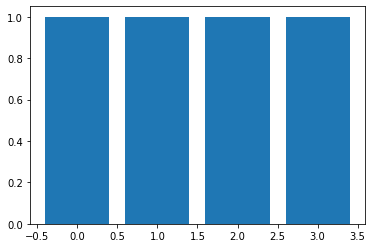

In [59]:
buildModel = ModelBuilder("",True)
buildModel.calculData(extractor.X, extractor.y)

In [ ]:
df = pd.read_csv('vgsales.csv', delimiter=",", index_col=0)